In [23]:
import tensorflow as tf
from tensorflow import keras

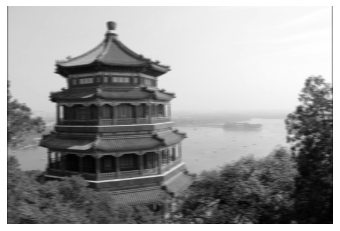

In [24]:
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

In [25]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

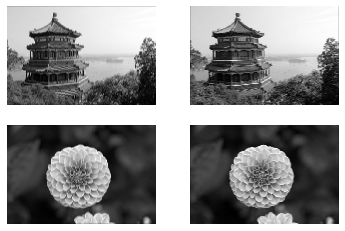

In [26]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

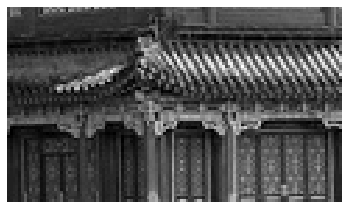

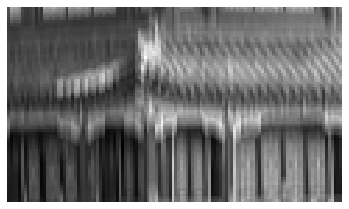

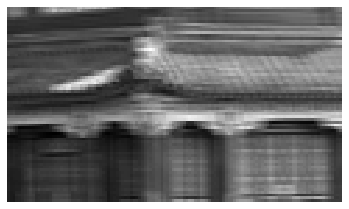

In [27]:
def crop(image):
    return image[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

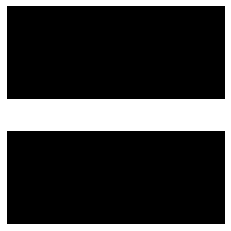

In [28]:
plot_image(filters[:, :, 0, 1])

In [29]:
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1, padding="same", activation="relu", input_shape=outputs.shape)
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

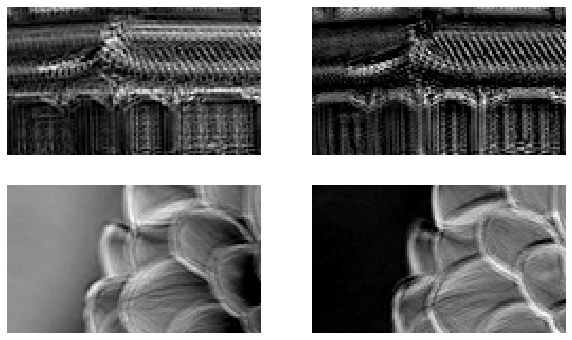

In [30]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [31]:
conv.set_weights([filters, np.zeros(2)])

In [32]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

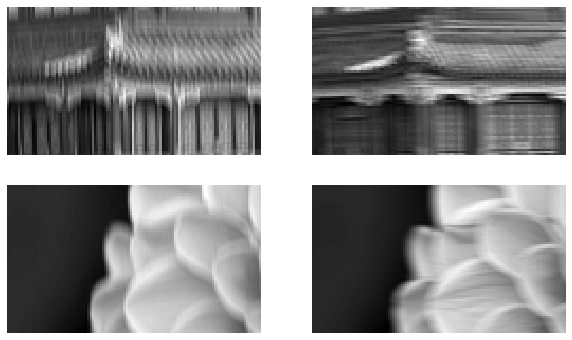

In [33]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [34]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [35]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

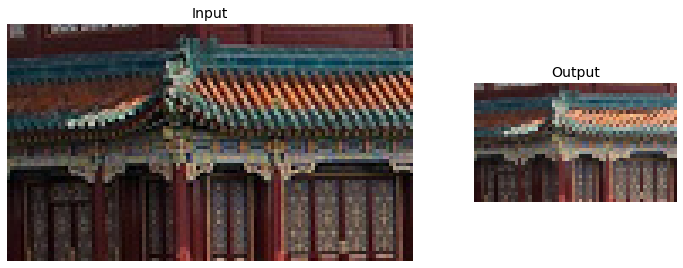

In [36]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

In [37]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    
    def call(self, inputs):
        return tf.nn.max_pool(inputs, ksize=(1, 1, 1, self.pool_size), strides=(1, 1, 1, self.pool_size), padding=self.padding)

In [38]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [39]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

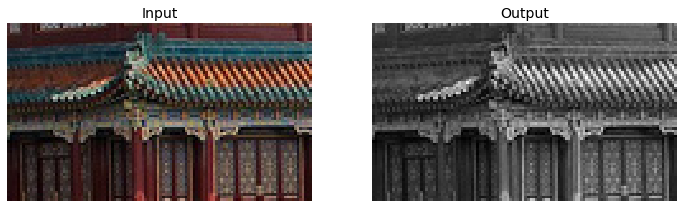

In [40]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")
plt.show()

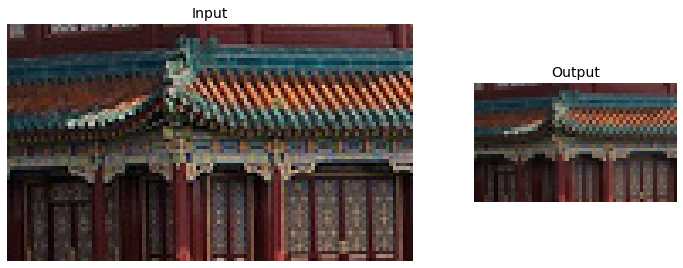

In [41]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

In [42]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

In [43]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [44]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation="relu", padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[np.random.randint(0,10):np.random.randint(10,20)]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 173s 100ms/step - loss: 0.6933 - accuracy: 0.7595 - val_loss: 0.3938 - val_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 174s 101ms/step - loss: 0.4186 - accuracy: 0.8600 - val_loss: 0.3265 - val_accuracy: 0.8844
Epoch 3/10
1719/1719 [==============================] - 166s 97ms/step - loss: 0.3667 - accuracy: 0.8766 - val_loss: 0.3336 - val_accuracy: 0.8750
Epoch 4/10
1719/1719 [==============================] - 165s 96ms/step - loss: 0.3384 - accuracy: 0.8877 - val_loss: 0.3170 - val_accuracy: 0.8894
Epoch 5/10
1719/1719 [==============================] - 167s 97ms/step - loss: 0.3126 - accuracy: 0.8944 - val_loss: 0.2723 - val_accuracy: 0.9042
Epoch 6/10
1719/1719 [==============================] - 172s 100ms/step - loss: 0.2972 - accuracy: 0.8981 - val_loss: 0.2937 - val_accuracy: 0.8980
Epoch 7/10
1719/1719 [==============================] - 170s 99ms/step - loss: 0.2840 - accuracy: 0.9036 - val_loss

In [45]:
print(score)
print(y_pred)

[0.3150791525840759, 0.8988000154495239]
[[2.3271669e-17 3.5178811e-26 1.8537016e-18 9.8880026e-17 1.6815030e-19
  9.9999475e-01 1.3726090e-16 5.2430014e-06 1.3771605e-10 2.7946058e-08]
 [1.5677791e-25 1.8681257e-29 1.8316277e-31 2.8642638e-29 1.5220053e-30
  2.9308984e-09 1.4095003e-22 1.0000000e+00 2.9895817e-25 1.0034179e-08]
 [1.0483295e-06 1.0025490e-10 2.1739425e-02 1.0474141e-06 9.5890176e-01
  8.4938386e-17 1.9356681e-02 1.0218359e-16 1.5453799e-10 4.2565964e-15]]


In [46]:
# keras.backend.clear_session()

In [47]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# LeNet-5

model = keras.models.Sequential()
model.add(keras.layers.ZeroPadding2D(padding=2, input_shape=[28, 28, 1]))
model.add(keras.layers.Conv2D(6, kernel_size=5, strides=1, activation="tanh"))
model.add(keras.layers.MaxPooling2D(2, strides=2))
model.add(keras.layers.Conv2D(16, kernel_size=5, strides=1, activation="tanh"))
model.add(keras.layers.MaxPooling2D(2, strides=2))
model.add(keras.layers.Conv2D(120, kernel_size=5, strides=1, activation="tanh"))
model.add(keras.layers.Dense(84, activation="tanh"))
model.add(keras.layers.Dense(10, activation="softmax"))     # rbf? -> softmax

In [48]:
# AlexNet

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(96, kernel_size=11, strides=4, padding="VALID", activation="relu", input_shape=[227, 227, 3]))
model.add(keras.layers.MaxPooling2D(3, strides=2, padding="VALID"))
model.add(keras.layers.Conv2D(256, kernel_size=5, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.MaxPooling2D(3, strides=2, padding="VALID"))
model.add(keras.layers.Conv2D(384, kernel_size=3, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.Conv2D(384, kernel_size=3, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.MaxPooling2D(3, strides=2, padding="VALID"))
model.add(keras.layers.Dense(4096, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1000, activation="softmax"))

In [51]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers=[
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
        ]
        self.skip_layers=[]

        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization(),
            ]

    def call(self, inputs):
        Z = inputs
        
        for layer in self.main_layers:
            Z = layer(Z)
        
        skip_Z = inputs

        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

In [52]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64

for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [59]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 8s 0us/step


In [60]:
images_resize = tf.image.resize(images, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resize * 255)
Y_proba = model.predict(inputs)

In [61]:
Y_proba.shape

(2, 1000)

이미지 #0


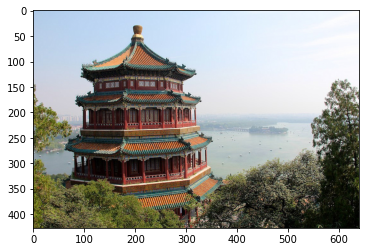

 n02825657 - bell_cote    82.35%
 n03877845 - palace       6.75%
 n03781244 - monastery    4.19%

이미지 #1


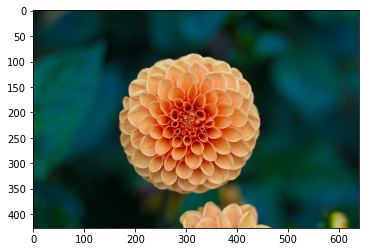

 n03530642 - honeycomb    49.81%
 n13040303 - stinkhorn    33.96%
 n02206856 - bee          4.35%



In [65]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"이미지 #{image_index}")
    plt.imshow(images[image_index])
    plt.show()
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

In [66]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...: 100%|██████████| 1/1 [00:19<00:00, 19.19s/ url]
                                                                        

Dataset tf_flowers downloaded and prepared to C:\Users\ozing\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [67]:
info.splits

{Split('train'): <SplitInfo num_examples=3670, num_shards=2>}

In [68]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [72]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [73]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

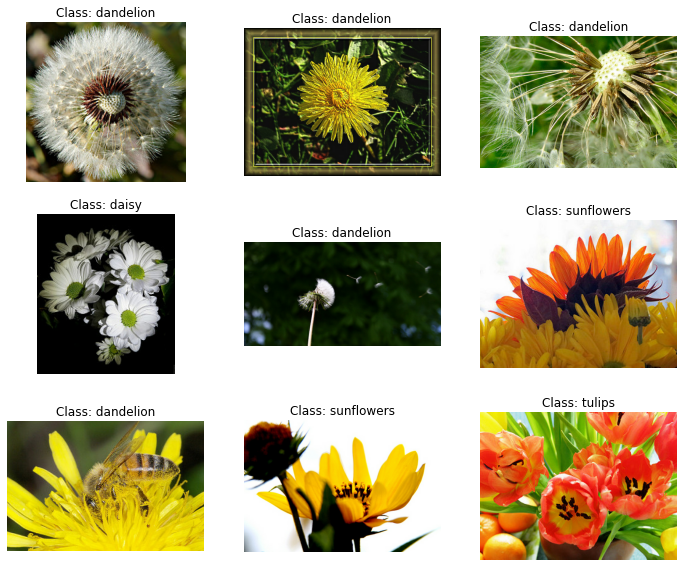

In [74]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [75]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [76]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [83]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [84]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_4
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_61
13 block2_pool
14 batch_normalization_41
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_62
23 block3_pool
24 batch_normalization_42
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_63
33 block4_pool
34 batch_normalization_43
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [87]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size), validation_data=valid_set, validation_steps=int(0.15 * dataset_size / batch_size), epochs=5)

Epoch 1/5
86/86 [==============================] - 125s 1s/step - loss: 0.9093 - accuracy: 0.8154 - val_loss: 0.7660 - val_accuracy: 0.8290
Epoch 2/5
86/86 [==============================] - 123s 1s/step - loss: 0.4623 - accuracy: 0.8972 - val_loss: 0.6914 - val_accuracy: 0.8585
Epoch 3/5
86/86 [==============================] - 123s 1s/step - loss: 0.2581 - accuracy: 0.9266 - val_loss: 0.6228 - val_accuracy: 0.8529
Epoch 4/5
86/86 [==============================] - 123s 1s/step - loss: 0.1926 - accuracy: 0.9455 - val_loss: 0.7085 - val_accuracy: 0.8493
Epoch 5/5
86/86 [==============================] - 123s 1s/step - loss: 0.1883 - accuracy: 0.9451 - val_loss: 0.5177 - val_accuracy: 0.8750


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size), validation_data=valid_set, validation_steps=int(0.15 * dataset_size / batch_size), epochs=40)